# <span style="color:midnightblue"> Part 2: Real Estate Market Data Exploration in major French Cities 

 ##### Alexandra AMIENS, Claire ZOUAOUI et Julieva COHEN-SORS

<span style="color:midnightblue"> The objective of the project is to perform real estate data exploration of major French cities.
The company (Immo-Inv) is a real estate agency who wants to understand very well the real estate market in France.
As a big data analyst of the company and we have access to a 5-years data history of real estate transactions in France (real_estate_transactions.csv).
The dataset contains details for each transaction: sale date, localization (city,
postal code), type of residence, type of sale, land area, living area, number of
rooms, price, etc.).

On our work we will explore all possible aspects of this real estate market.
At the end we will came with 6 findings:

1- High cost / low cost cities depending on the price per M2
    
2- Analysis of the value of cities and their communes regarding the prices (Cluster Analysis)
    
3- Evolution of the prices (per cluster) per year

4- Dynamism of the Real estate market: The most Attractive City, regarding the number of sales registered
    
5- Difference of number of House and Apartement sold per cities over the years
    
6- The Prices Difference between Houses and Apartment


## <span style="color:midnightblue"> Import the Data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import pyspark

In [2]:
sc = pyspark.SparkContext(appName="Spark-RDD-Real-Estate")

In [3]:
realestate = 'real_estate_transactions.csv'

In [4]:
rdd_realestate = sc.textFile(realestate)\
                   .map(lambda line: line.split(";"))\
                   .filter(lambda line: len(line)>1) \
                   .map(lambda line: (line[0:]))

rdd_realestate.take(10)

[['City',
  'Sale Date',
  'Sale Type',
  'Price',
  'Postal Code',
  'Commune',
  'Number of lots',
  'Local Type',
  'Living Area',
  'Number of rooms',
  'Land Area'],
 ['NICE',
  '26/03/2015',
  'SALE',
  '102000,00',
  '6000',
  'NICE',
  '1',
  'APARTMENT',
  '29',
  '2',
  ''],
 ['NICE',
  '07/04/2015',
  'SALE',
  '32000,00',
  '6000',
  'NICE',
  '1',
  'DEPENDENCY',
  '0',
  '0',
  ''],
 ['NICE',
  '10/04/2015',
  'SALE',
  '239000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '51',
  '2',
  ''],
 ['NICE',
  '10/04/2015',
  'SALE',
  '239000,00',
  '6200',
  'NICE',
  '1',
  'DEPENDENCY',
  '0',
  '0',
  ''],
 ['NICE',
  '23/03/2015',
  'SALE',
  '30000,00',
  '6000',
  'NICE',
  '1',
  'DEPENDENCY',
  '0',
  '0',
  ''],
 ['NICE',
  '23/03/2015',
  'SALE',
  '410000,00',
  '6200',
  'NICE',
  '2',
  'APARTMENT',
  '60',
  '3',
  ''],
 ['NICE',
  '08/04/2015',
  'SALE',
  '215000,00',
  '6200',
  'NICE',
  '1',
  'DEPENDENCY',
  '0',
  '0',
  ''],
 ['NICE',
  '08/04/2015',


In [5]:
rdd_realestate.first()

['City',
 'Sale Date',
 'Sale Type',
 'Price',
 'Postal Code',
 'Commune',
 'Number of lots',
 'Local Type',
 'Living Area',
 'Number of rooms',
 'Land Area']

In [6]:
top = rdd_realestate.first()
rdd_realestate = rdd_realestate.filter(lambda line: line != top) 
rdd_realestate.count()

909724

## <span style="color:midnightblue"> Data Cleaning

### <span style="color:midnightblue"> Removing outliers

#### <span style="color:midnightblue"> Sale Type:keep only "SALE" and "SALE BEFORE COMPLETION" transactions 

In [7]:
rdd_realestate.map(lambda field: field[2]).distinct().count()


6

There are 6 different types of transactions:
- Adjudication
- Exchange
- Expropriation
- Land Only Sale
- Sale
- Sale Before Completion

In [8]:
rdd_realestate = rdd_realestate.filter(lambda tuple: tuple[2] == 'SALE BEFORE COMPLETION' or tuple[2] == 'SALE')

rdd_realestate.map(lambda tuple: (tuple[2],1))\
              .reduceByKey(lambda x,y : x+y)\
              .take(2)

[('SALE BEFORE COMPLETION', 147708), ('SALE', 754464)]

In [9]:
rdd_realestate.map(lambda tuple: tuple[2]).distinct().count()

2

In order to simplify the analalysis, after modifications only two types remains:
- Sale
- Sale Before Completion


In [10]:
rdd_realestate.count()

902172

#### <span style="color:midnightblue"> Local Type: keep only "APARTMENT" and "HOUSE"

In [11]:
rdd_realestate.map(lambda field: field[7]).distinct().count()


5

There are 5 Local Types :
- Apartment
- House
- Industrial
- Dependency
- (Empty)


In [12]:
rdd_realestate = rdd_realestate.filter(lambda tuple: tuple[7] == 'HOUSE' or tuple[7] == 'APARTMENT')

rdd_realestate.map(lambda tuple: (tuple[7],1))\
              .reduceByKey(lambda x,y : x+y)\
              .take(2)


[('APARTMENT', 445686), ('HOUSE', 37619)]

In [13]:
rdd_realestate.map(lambda tuple: tuple[7]).distinct().count()

2

Also in order to simplify the coming analysis, let's keep only two types of Local:
 - Apartment
 - House

In [14]:
rdd_realestate.count()

483305

#### <span style="color:midnightblue"> Remove transactions without prices, postal code, rooms and living area 

In [16]:
rdd_realestate = rdd_realestate.filter(lambda tuple: tuple[9] != '')\
                                   .filter(lambda tuple: tuple[8] != '')\
                                   .filter(lambda tuple: tuple[4] != '')\
                                   .filter(lambda tuple: tuple[3] != '')

rdd_realestate.take(10)

[['NICE',
  '26/03/2015',
  'SALE',
  '102000,00',
  '6000',
  'NICE',
  '1',
  'APARTMENT',
  '29',
  '2',
  ''],
 ['NICE',
  '10/04/2015',
  'SALE',
  '239000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '51',
  '2',
  ''],
 ['NICE',
  '23/03/2015',
  'SALE',
  '410000,00',
  '6200',
  'NICE',
  '2',
  'APARTMENT',
  '60',
  '3',
  ''],
 ['NICE',
  '08/04/2015',
  'SALE',
  '215000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '67',
  '3',
  ''],
 ['NICE',
  '20/03/2015',
  'SALE',
  '625000,00',
  '6200',
  'NICE',
  '0',
  'HOUSE',
  '160',
  '5',
  '500'],
 ['NICE',
  '20/03/2015',
  'SALE',
  '625000,00',
  '6200',
  'NICE',
  '0',
  'HOUSE',
  '160',
  '5',
  '1267'],
 ['NICE',
  '02/04/2015',
  'SALE',
  '130000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '31',
  '1',
  ''],
 ['NICE',
  '24/03/2015',
  'SALE',
  '115000,00',
  '6000',
  'NICE',
  '2',
  'APARTMENT',
  '50',
  '2',
  ''],
 ['NICE',
  '03/04/2015',
  'SALE',
  '172500,00',
  '6100',
  'NICE',
  '2',
 

In [17]:
rdd_realestate.count()

478005

#### <span style="color:midnightblue"> Replace null values for land area with a default value
We replace null values with 0 

In [18]:
def replacebyzero(zero):
    if zero[10] != '': 
        return zero
    else: 
        zero[10] = 0
        return zero

rdd_realestate = rdd_realestate.map(lambda zero: replacebyzero(zero))

rdd_realestate.take(10)


[['NICE',
  '26/03/2015',
  'SALE',
  '102000,00',
  '6000',
  'NICE',
  '1',
  'APARTMENT',
  '29',
  '2',
  0],
 ['NICE',
  '10/04/2015',
  'SALE',
  '239000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '51',
  '2',
  0],
 ['NICE',
  '23/03/2015',
  'SALE',
  '410000,00',
  '6200',
  'NICE',
  '2',
  'APARTMENT',
  '60',
  '3',
  0],
 ['NICE',
  '08/04/2015',
  'SALE',
  '215000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '67',
  '3',
  0],
 ['NICE',
  '20/03/2015',
  'SALE',
  '625000,00',
  '6200',
  'NICE',
  '0',
  'HOUSE',
  '160',
  '5',
  '500'],
 ['NICE',
  '20/03/2015',
  'SALE',
  '625000,00',
  '6200',
  'NICE',
  '0',
  'HOUSE',
  '160',
  '5',
  '1267'],
 ['NICE',
  '02/04/2015',
  'SALE',
  '130000,00',
  '6200',
  'NICE',
  '1',
  'APARTMENT',
  '31',
  '1',
  0],
 ['NICE',
  '24/03/2015',
  'SALE',
  '115000,00',
  '6000',
  'NICE',
  '2',
  'APARTMENT',
  '50',
  '2',
  0],
 ['NICE',
  '03/04/2015',
  'SALE',
  '172500,00',
  '6100',
  'NICE',
  '2',
  'APAR

In [19]:
rdd_realestate.count()

478005

#### <span style="color:midnightblue"> Fix the data type 

We change the type of the numerical fields such as Price (3), Number of Lots (6), Living Area (8), number of rooms (9) and Land Area (10).


In [20]:
def FixType(field):
        field[3] = field[3].split(',')[0]
        field[3] = int(field[3])
        field[6] = int(field[6])
        field[8] = float(field[8])
        field[9] = int(field[9])
        field[10] = float(field[10])
        
        return field

rdd_realestate = rdd_realestate.map(lambda field: FixType(field))

rdd_realestate.take(10)

[['NICE',
  '26/03/2015',
  'SALE',
  102000,
  '6000',
  'NICE',
  1,
  'APARTMENT',
  29.0,
  2,
  0.0],
 ['NICE',
  '10/04/2015',
  'SALE',
  239000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  51.0,
  2,
  0.0],
 ['NICE',
  '23/03/2015',
  'SALE',
  410000,
  '6200',
  'NICE',
  2,
  'APARTMENT',
  60.0,
  3,
  0.0],
 ['NICE',
  '08/04/2015',
  'SALE',
  215000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  67.0,
  3,
  0.0],
 ['NICE',
  '20/03/2015',
  'SALE',
  625000,
  '6200',
  'NICE',
  0,
  'HOUSE',
  160.0,
  5,
  500.0],
 ['NICE',
  '20/03/2015',
  'SALE',
  625000,
  '6200',
  'NICE',
  0,
  'HOUSE',
  160.0,
  5,
  1267.0],
 ['NICE',
  '02/04/2015',
  'SALE',
  130000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  31.0,
  1,
  0.0],
 ['NICE',
  '24/03/2015',
  'SALE',
  115000,
  '6000',
  'NICE',
  2,
  'APARTMENT',
  50.0,
  2,
  0.0],
 ['NICE',
  '03/04/2015',
  'SALE',
  172500,
  '6100',
  'NICE',
  2,
  'APARTMENT',
  63.0,
  4,
  0.0],
 ['NICE',
  '09/04/2015',
  'SALE',
  

In [21]:
rdd_realestate.count()


478005

In [22]:
rdd_clean_realestate = rdd_realestate

In [23]:
rdd_clean_realestate.take(1)

[['NICE',
  '26/03/2015',
  'SALE',
  102000,
  '6000',
  'NICE',
  1,
  'APARTMENT',
  29.0,
  2,
  0.0]]

#### <span style="color:midnightblue"> Adding a new field

We create a new field: Price per square meter

In [24]:
def PriceM2(field):
        field.append(int(field[3])/int(field[8]))
        return field



In [25]:
rdd_clean_realestate = rdd_clean_realestate.map(lambda field: PriceM2(field))

rdd_clean_realestate.take(10)

[['NICE',
  '26/03/2015',
  'SALE',
  102000,
  '6000',
  'NICE',
  1,
  'APARTMENT',
  29.0,
  2,
  0.0,
  3517.2413793103447],
 ['NICE',
  '10/04/2015',
  'SALE',
  239000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  51.0,
  2,
  0.0,
  4686.274509803921],
 ['NICE',
  '23/03/2015',
  'SALE',
  410000,
  '6200',
  'NICE',
  2,
  'APARTMENT',
  60.0,
  3,
  0.0,
  6833.333333333333],
 ['NICE',
  '08/04/2015',
  'SALE',
  215000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  67.0,
  3,
  0.0,
  3208.955223880597],
 ['NICE',
  '20/03/2015',
  'SALE',
  625000,
  '6200',
  'NICE',
  0,
  'HOUSE',
  160.0,
  5,
  500.0,
  3906.25],
 ['NICE',
  '20/03/2015',
  'SALE',
  625000,
  '6200',
  'NICE',
  0,
  'HOUSE',
  160.0,
  5,
  1267.0,
  3906.25],
 ['NICE',
  '02/04/2015',
  'SALE',
  130000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  31.0,
  1,
  0.0,
  4193.548387096775],
 ['NICE',
  '24/03/2015',
  'SALE',
  115000,
  '6000',
  'NICE',
  2,
  'APARTMENT',
  50.0,
  2,
  0.0,
  2300.0],
 ['NICE

In [26]:
rdd_clean_realestate.count()

478005

## <span style="color:midnightblue"> Data Exploration 

Here the aim is to better understand the dataset. To do so, we will use SQL queries.

In [27]:
import pyspark

spark = pyspark.sql.SparkSession.builder.appName("Spark-Real-Estate-DF").getOrCreate()

#### <span style="color:midnightblue"> Create DataFrame

In [28]:
realestate_df = spark.read.csv('real_estate_transactions.csv', header=True, sep=';')

realestate_df.show(5)

+----+----------+---------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+
|City| Sale Date|Sale Type|    Price|Postal Code|Commune|Number of lots|Local Type|Living Area|Number of rooms|Land Area|
+----+----------+---------+---------+-----------+-------+--------------+----------+-----------+---------------+---------+
|NICE|26/03/2015|     SALE|102000,00|       6000|   NICE|             1| APARTMENT|         29|              2|     null|
|NICE|07/04/2015|     SALE| 32000,00|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|10/04/2015|     SALE|239000,00|       6200|   NICE|             1| APARTMENT|         51|              2|     null|
|NICE|10/04/2015|     SALE|239000,00|       6200|   NICE|             1|DEPENDENCY|          0|              0|     null|
|NICE|23/03/2015|     SALE| 30000,00|       6000|   NICE|             1|DEPENDENCY|          0|              0|     null|
+----+----------+-------

In [29]:
transaction_df = rdd_clean_realestate.toDF(['City','Sale Date','Sale type','Price', 'Postal Code', 'Commune', 'Number of lots', 'Local Type', 'Living_Area', 'Number of rooms', 'Land Area', 'PriceM2'])

transaction_df.show(5)

+----+----------+---------+------+-----------+-------+--------------+----------+-----------+---------------+---------+------------------+
|City| Sale Date|Sale type| Price|Postal Code|Commune|Number of lots|Local Type|Living_Area|Number of rooms|Land Area|           PriceM2|
+----+----------+---------+------+-----------+-------+--------------+----------+-----------+---------------+---------+------------------+
|NICE|26/03/2015|     SALE|102000|       6000|   NICE|             1| APARTMENT|       29.0|              2|      0.0|3517.2413793103447|
|NICE|10/04/2015|     SALE|239000|       6200|   NICE|             1| APARTMENT|       51.0|              2|      0.0| 4686.274509803921|
|NICE|23/03/2015|     SALE|410000|       6200|   NICE|             2| APARTMENT|       60.0|              3|      0.0| 6833.333333333333|
|NICE|08/04/2015|     SALE|215000|       6200|   NICE|             1| APARTMENT|       67.0|              3|      0.0| 3208.955223880597|
|NICE|20/03/2015|     SALE|625000|

In [30]:
transaction_df.createOrReplaceTempView('transaction')

#### <span style="color:midnightblue"> Mean(), Max() and Min() of the prices and the prices per square meter per city. 

In [31]:
transaction_df_AVG = spark.sql("SELECT City, AVG(Price), AVG(PriceM2) FROM transaction GROUP BY City ORDER BY AVG(Price) desc ")
transaction_df_AVG.show()

transaction_df_MAX = spark.sql("SELECT City, MAX(Price), MAX(PriceM2) FROM transaction GROUP BY City ORDER BY MAX(Price) desc ")
transaction_df_MAX.show()

transaction_df_MIN = spark.sql("SELECT City, MIN(Price), MIN(PriceM2) FROM transaction GROUP BY City ORDER BY MIN(Price) desc ")
transaction_df_MIN.show()

+-----------+------------------+------------------+
|       City|        avg(Price)|      avg(PriceM2)|
+-----------+------------------+------------------+
|      PARIS|2820970.7549767476| 80091.18801627915|
|  MARSEILLE| 985149.0437140847|22155.817715384645|
|       LYON|   796163.74223877|13104.847848806448|
|MONTPELLIER| 663993.0523888363| 22793.52100848133|
|   TOULOUSE| 662720.5636748436|13416.682287463054|
|     NANTES| 642943.3376320696| 11888.56279742981|
|   BORDEAUX| 607578.0414770178| 11257.58503614878|
|       NICE|350616.91600085224| 6583.005407132812|
|      LILLE| 308442.1145959458| 7539.797814536508|
+-----------+------------------+------------------+

+-----------+----------+------------------+
|       City|max(Price)|      max(PriceM2)|
+-----------+----------+------------------+
|      PARIS|1249132030|      1.24913203E8|
|  MARSEILLE| 378000000|         5320000.0|
|MONTPELLIER| 174814352| 4600377.684210527|
|       LYON|  77600000| 4564705.882352941|
|     NANTES|  

## <span style="color:midnightblue"> Finding 1 : Price per square meter per City

In [32]:
priceM2_df =  spark.sql(" SELECT City, avg(Price)/avg(Living_Area) as priceM2 \
                          FROM transaction \
                          WHERE Price < 10000000 AND Price> 20000 \
                          GROUP BY City \
                          ORDER BY priceM2 desc ")

priceM2_df.show(10)

+-----------+------------------+
|       City|           priceM2|
+-----------+------------------+
|      PARIS|13652.219217444082|
|       LYON| 7741.109260451366|
|   BORDEAUX| 6661.304091902846|
|   TOULOUSE| 6630.711393504149|
|MONTPELLIER| 6482.784445124738|
|  MARSEILLE| 5975.487570248354|
|       NICE| 5948.597607560817|
|      LILLE| 5275.205853387303|
|     NANTES| 5165.936728486331|
+-----------+------------------+



The table shows that Paris seems to be the more expensive city with an average of 13 652 € per square meter.
We choose to frame the price between 20 000€ and 10 000 000€ in order to exclude outliers.

In [33]:
PriceM2_pd= spark.sql(" SELECT City, avg(Price)/avg(Living_Area) as priceM2 \
                          FROM transaction \
                          WHERE Price < 10000000 AND Price> 20000 \
                          GROUP BY City \
                          ORDER BY priceM2 desc ").toPandas()

In [34]:
PriceM2_pd

,City,priceM2
0,PARIS,13652.219217
1,LYON,7741.109260
2,BORDEAUX,6661.304092
3,TOULOUSE,6630.711394
4,MONTPELLIER,6482.784445
5,MARSEILLE,5975.487570
6,NICE,5948.597608
7,LILLE,5275.205853
8,NANTES,5165.936728


Text(0.5, 1.0, 'Price per M² per City')

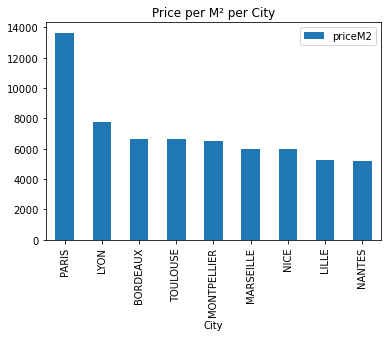

In [35]:
barplot = PriceM2_pd.plot.bar(x='City', y='priceM2')
plt.title('Price per M² per City')

#### <span style="color:midnightblue"> Finding 1 Conclusion : 
We can notice a clear distinction with prices in Paris and maybe a second group including Lyon, Bordeaux and Toulouse. This statement will help us later to build the cluster analysis. 


### <span style="color:midnightblue"> Studying the repartition of the prices values

In [36]:
spark.sql("SELECT CITY, PriceM2 FROM transaction").show()

+----+------------------+
|CITY|           PriceM2|
+----+------------------+
|NICE|3517.2413793103447|
|NICE| 4686.274509803921|
|NICE| 6833.333333333333|
|NICE| 3208.955223880597|
|NICE|           3906.25|
|NICE|           3906.25|
|NICE| 4193.548387096775|
|NICE|            2300.0|
|NICE| 2738.095238095238|
|NICE|3302.7522935779816|
|NICE|               0.0|
|NICE|3772.7272727272725|
|NICE| 3054.794520547945|
|NICE| 4909.090909090909|
|NICE|1893.3333333333333|
|NICE| 3723.684210526316|
|NICE| 2337.837837837838|
|NICE|            5280.0|
|NICE|            4500.0|
|NICE| 3190.253164556962|
+----+------------------+
only showing top 20 rows



In [37]:
boxplt = spark.sql("SELECT CITY, PriceM2 FROM transaction WHERE PriceM2 < 100000 AND PriceM2> 0  ").toPandas()
boxplt


,CITY,PriceM2
0,NICE,3517.241379
1,NICE,4686.274510
2,NICE,6833.333333
3,NICE,3208.955224
4,NICE,3906.250000
...,...,...
461069,PARIS,8174.603175
461070,PARIS,8559.322034
461071,PARIS,8345.679012
461072,PARIS,14689.075630


Text(0.5, 1.0, 'Boxplot: City and Price per m²')

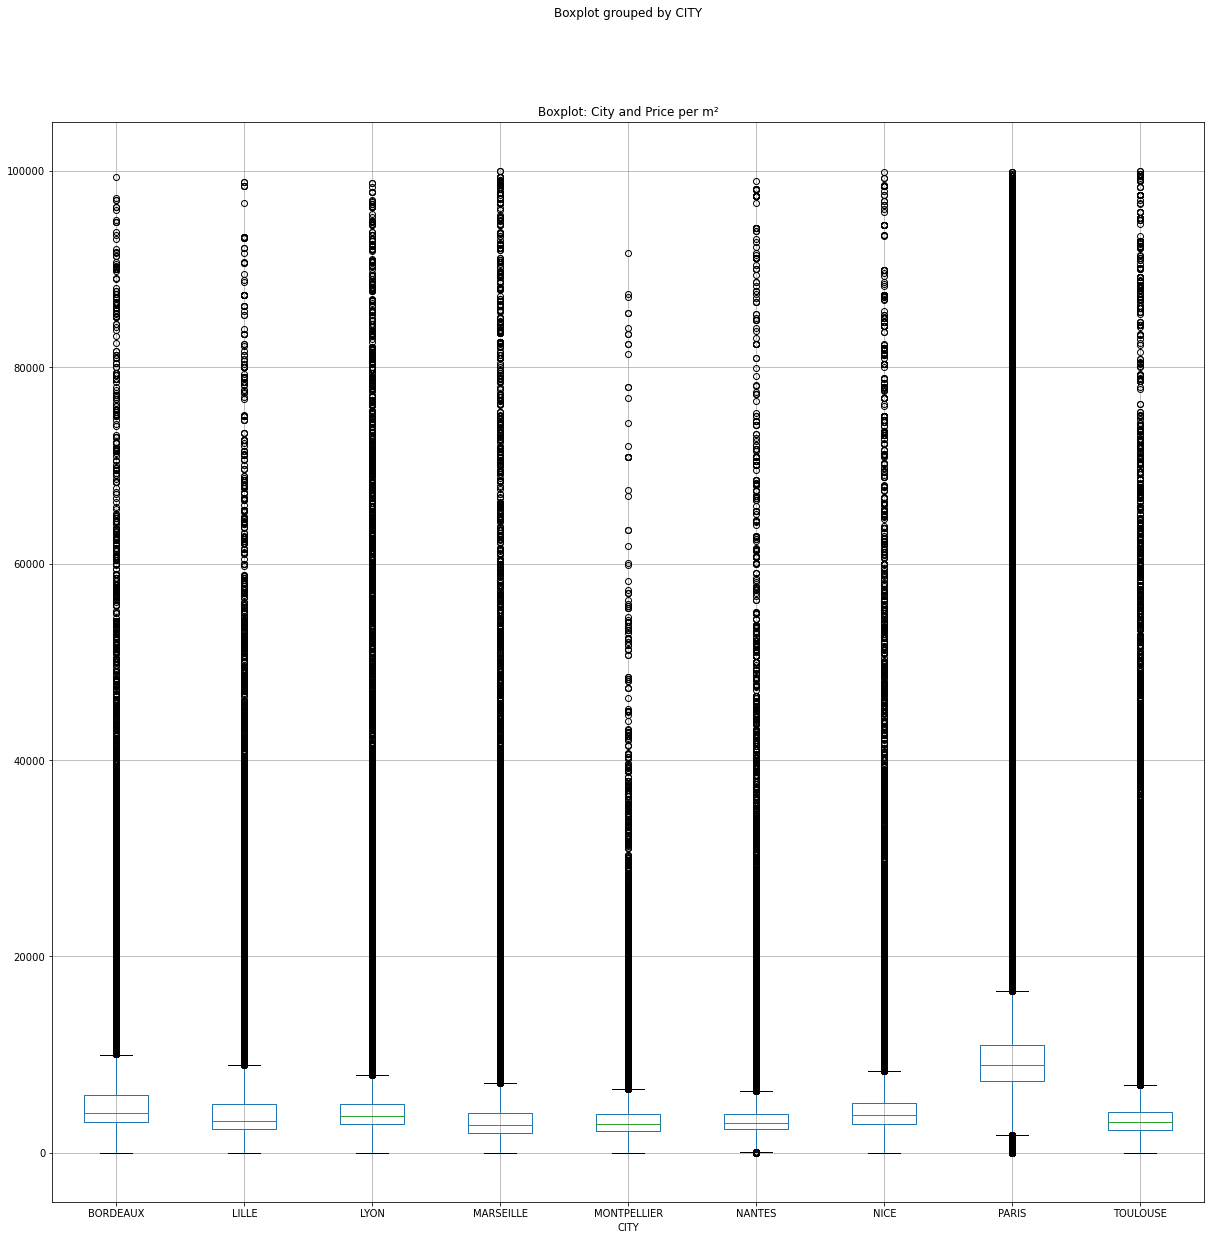

In [38]:
boxplt.boxplot(column='PriceM2', by='CITY', figsize=(20, 20))
plt.title('Boxplot: City and Price per m²')

On the boxplot above, even by filtering the price per m² under 100 000€ , the values are too much scattered. 
Thus, on the next step, we need to add more filters and personalize the filtering by city.

### <span style="color:midnightblue"> Search for more outliers : Filtering the prices


#### <span style="color:midnightblue"> Price per Square Meter Filtering

The price per M² is now the field 11. 
The range have been determined by analysing the explorative data (Avg, max, min per m²) done on the SQL queries above and the scatterplot, 2 lines before. 

In [39]:
def filterPricePerM2PerCity(field):
    if field[0] == 'PARIS' and 1700 <= field[11] <= 16500:
        return field 
    elif field[0] == 'LYON' and 1600 <= field[11] <= 16000:
        return field 
    elif field[0] == 'BORDEAUX' and 1300 <= field[11] <= 15000:
        return field 
    elif field[0] == 'TOULOUSE' and 1100 <= field[11] <= 14000:
        return field
    elif field[0] == 'MONTPELLIER' and 1000 <= field[11] <= 13000:
        return field
    elif field[0] == 'MARSEILLE' and 1300 <= field[11] <= 12000:
        return field 
    elif field[0] == 'NICE' and 1300 <= field[11] <= 12000:
        return field
    elif field[0] == 'LILLE' and 1100 <= field[11] <= 10000:
        return field
    elif field[0] == 'NANTES' and 1100 <= field[11] <= 10000: 
        return field


In [40]:
rdd_clean_realestate = rdd_clean_realestate.map(lambda field : filterPricePerM2PerCity(field))\
                                      .filter(lambda field : field != None)

rdd_clean_realestate.take(10)

[['NICE',
  '26/03/2015',
  'SALE',
  102000,
  '6000',
  'NICE',
  1,
  'APARTMENT',
  29.0,
  2,
  0.0,
  3517.2413793103447],
 ['NICE',
  '10/04/2015',
  'SALE',
  239000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  51.0,
  2,
  0.0,
  4686.274509803921],
 ['NICE',
  '23/03/2015',
  'SALE',
  410000,
  '6200',
  'NICE',
  2,
  'APARTMENT',
  60.0,
  3,
  0.0,
  6833.333333333333],
 ['NICE',
  '08/04/2015',
  'SALE',
  215000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  67.0,
  3,
  0.0,
  3208.955223880597],
 ['NICE',
  '20/03/2015',
  'SALE',
  625000,
  '6200',
  'NICE',
  0,
  'HOUSE',
  160.0,
  5,
  500.0,
  3906.25],
 ['NICE',
  '20/03/2015',
  'SALE',
  625000,
  '6200',
  'NICE',
  0,
  'HOUSE',
  160.0,
  5,
  1267.0,
  3906.25],
 ['NICE',
  '02/04/2015',
  'SALE',
  130000,
  '6200',
  'NICE',
  1,
  'APARTMENT',
  31.0,
  1,
  0.0,
  4193.548387096775],
 ['NICE',
  '24/03/2015',
  'SALE',
  115000,
  '6000',
  'NICE',
  2,
  'APARTMENT',
  50.0,
  2,
  0.0,
  2300.0],
 ['NICE

#### <span style="color:midnightblue"> Prices filtering

In [41]:
rdd_clean_realestate = rdd_clean_realestate.filter(lambda field : 20000 <= field[3] <= 10000000)
rdd_clean_realestate.count()

409628

## <span style="color:midnightblue"> Data visualization 

We convert the rdd rdd_clean_realestate to a dataframe : 

In [44]:
realestate_df2 = rdd_clean_realestate.toDF(['City','Sale Date','Sale Type','Price','Postal Code','Commune','Number of lots','Local Type','Living Area','Number of rooms','Land Area','PriceM2'])
realestate_df2.show(10)

+----+----------+---------+------+-----------+-------+--------------+----------+-----------+---------------+---------+------------------+
|City| Sale Date|Sale Type| Price|Postal Code|Commune|Number of lots|Local Type|Living Area|Number of rooms|Land Area|           PriceM2|
+----+----------+---------+------+-----------+-------+--------------+----------+-----------+---------------+---------+------------------+
|NICE|26/03/2015|     SALE|102000|       6000|   NICE|             1| APARTMENT|       29.0|              2|      0.0|3517.2413793103447|
|NICE|10/04/2015|     SALE|239000|       6200|   NICE|             1| APARTMENT|       51.0|              2|      0.0| 4686.274509803921|
|NICE|23/03/2015|     SALE|410000|       6200|   NICE|             2| APARTMENT|       60.0|              3|      0.0| 6833.333333333333|
|NICE|08/04/2015|     SALE|215000|       6200|   NICE|             1| APARTMENT|       67.0|              3|      0.0| 3208.955223880597|
|NICE|20/03/2015|     SALE|625000|

In [45]:
realestate_df2.createOrReplaceTempView('transaction2')

In [46]:
realestate_df2.printSchema()

root
 |-- City: string (nullable = true)
 |-- Sale Date: string (nullable = true)
 |-- Sale Type: string (nullable = true)
 |-- Price: long (nullable = true)
 |-- Postal Code: string (nullable = true)
 |-- Commune: string (nullable = true)
 |-- Number of lots: long (nullable = true)
 |-- Local Type: string (nullable = true)
 |-- Living Area: double (nullable = true)
 |-- Number of rooms: long (nullable = true)
 |-- Land Area: double (nullable = true)
 |-- PriceM2: double (nullable = true)



### <span style="color:midnightblue"> Repartition of the prices per city after all the modifications

<AxesSubplot:title={'center':'PriceM2'}, xlabel='CITY'>

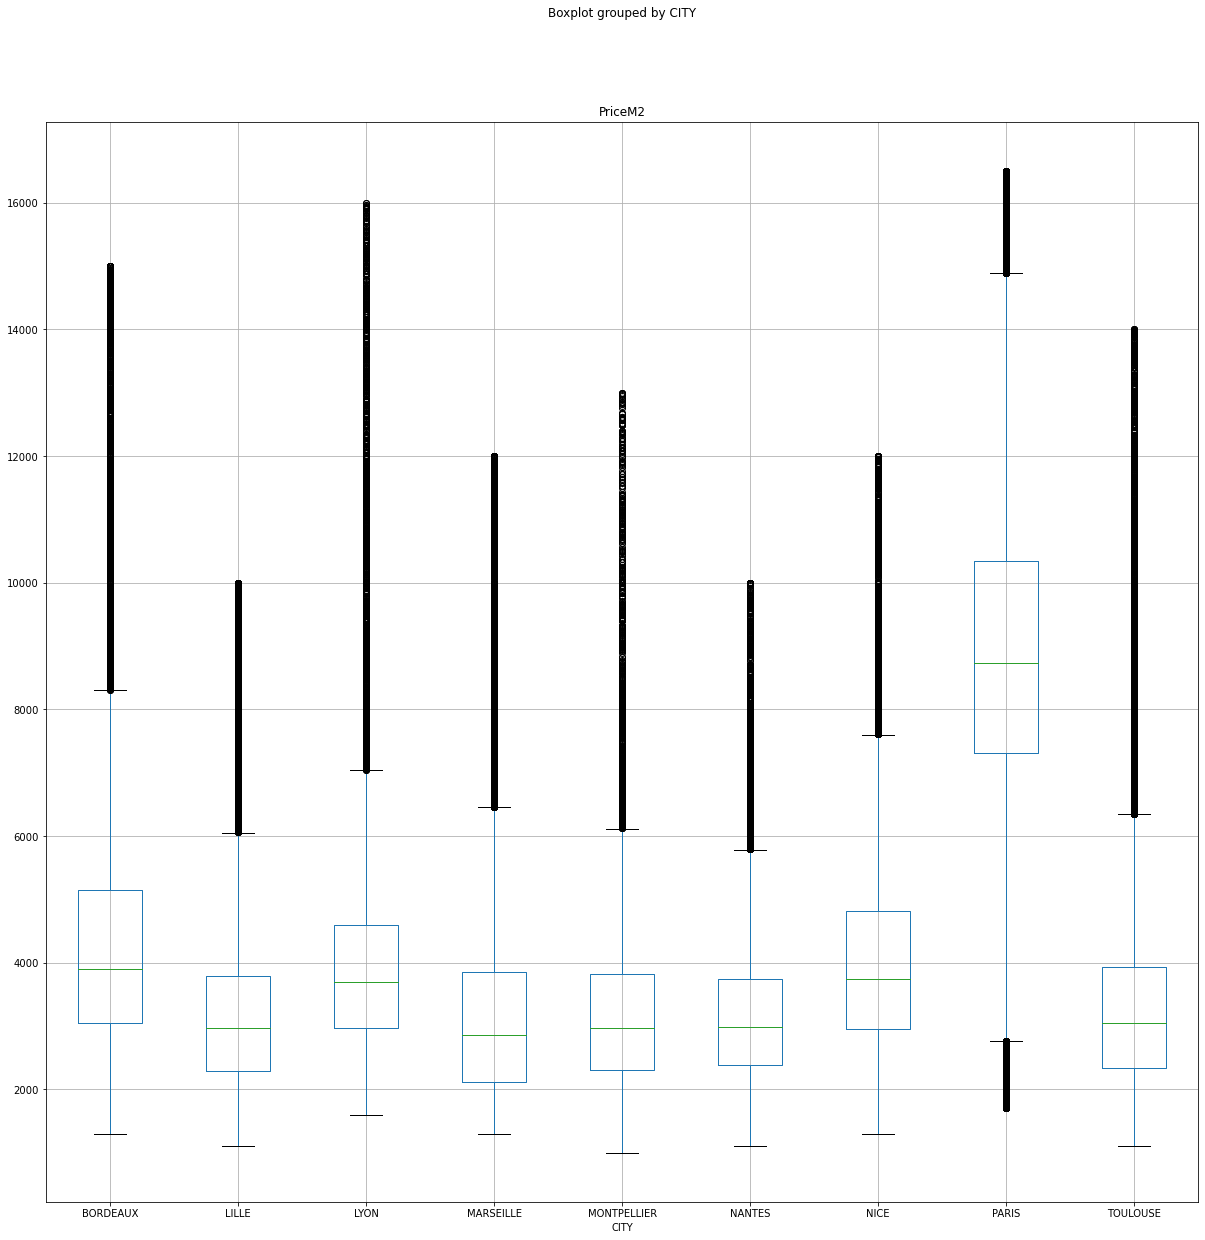

In [47]:
scaplot = spark.sql("SELECT CITY, PriceM2 FROM transaction2 ").toPandas()
scaplot.boxplot(column='PriceM2', by='CITY', figsize=(20, 20))

Thanks to the filtering price per m², the cleaning and the removing of outliers the values seems correctly distributed. 

We define 3 groups of price per city according to the SQL exploratory part and the tables that we calculated above showing the AVG(), MAX() and MIN().

In [48]:
def cluster(field):
    if field[0] == 'NANTES' or field[0] == 'MONTPELLIER' or field[0] == 'LILLE' or field[0] == 'MARSEILLE':
        field.append(2); 
        return field
    elif field[0] == 'LYON' or field[0] == 'TOULOUSE' or field[0]=='BORDEAUX' or field[0] == 'NICE' :
        field.append(1); 
        return field
    elif field[0] == 'PARIS': 
        field.append(0); 
        return field
    

rdd_clean_realestate = rdd_clean_realestate.map(lambda field : cluster(field))

In [49]:
from pyspark.sql.types import *



We use a schema in order to disable nullable values

In [50]:
re_schema =StructType ( [StructField("City", StringType(), False),
                           StructField("Sale Date", StringType(), False),
                           StructField("Sale Type", StringType(), False),
                           StructField("Price", LongType(), False),
                           StructField("Postal Code", StringType(), False),
                           StructField("Commune", StringType(), False),
                           StructField("Number of lots", LongType(), False),
                           StructField("Local Type", StringType(), False),
                           StructField("Living Area", DoubleType(), False),
                           StructField("Number of rooms", LongType(), False),
                           StructField("Land Area", DoubleType(), False),
                           StructField("PriceM2", DoubleType(), False),
                           StructField("Cluster", IntegerType(), False),
                        ] )

realestate_df2 = spark.createDataFrame(rdd_clean_realestate, re_schema)

realestate_df2.show(5)

+----+----------+---------+------+-----------+-------+--------------+----------+-----------+---------------+---------+------------------+-------+
|City| Sale Date|Sale Type| Price|Postal Code|Commune|Number of lots|Local Type|Living Area|Number of rooms|Land Area|           PriceM2|Cluster|
+----+----------+---------+------+-----------+-------+--------------+----------+-----------+---------------+---------+------------------+-------+
|NICE|26/03/2015|     SALE|102000|       6000|   NICE|             1| APARTMENT|       29.0|              2|      0.0|3517.2413793103447|      1|
|NICE|10/04/2015|     SALE|239000|       6200|   NICE|             1| APARTMENT|       51.0|              2|      0.0| 4686.274509803921|      1|
|NICE|23/03/2015|     SALE|410000|       6200|   NICE|             2| APARTMENT|       60.0|              3|      0.0| 6833.333333333333|      1|
|NICE|08/04/2015|     SALE|215000|       6200|   NICE|             1| APARTMENT|       67.0|              3|      0.0| 3208.

In [51]:
realestate_df2.printSchema()

root
 |-- City: string (nullable = false)
 |-- Sale Date: string (nullable = false)
 |-- Sale Type: string (nullable = false)
 |-- Price: long (nullable = false)
 |-- Postal Code: string (nullable = false)
 |-- Commune: string (nullable = false)
 |-- Number of lots: long (nullable = false)
 |-- Local Type: string (nullable = false)
 |-- Living Area: double (nullable = false)
 |-- Number of rooms: long (nullable = false)
 |-- Land Area: double (nullable = false)
 |-- PriceM2: double (nullable = false)
 |-- Cluster: integer (nullable = false)



In [52]:
realestate_df2.createOrReplaceTempView('transaction2')

### <span style="color:midnightblue"> Finding 2 : High and low value of the cities and the communes 

### <span style="color:midnightblue"> -- CLUSTER ANALYSIS --

We can test if the function cluster(field) well applies the number of the cluster 0, 1 and 2 to the good cities:

In [53]:
spark.sql(" SELECT City, AVG(PriceM2) as PriceperM2, Cluster \
                          FROM transaction2 \
                          GROUP BY City, Cluster \
                          ORDER BY PriceperM2 DESC ").show()



+-----------+------------------+-------+
|       City|        PriceperM2|Cluster|
+-----------+------------------+-------+
|      PARIS|  8885.80228605206|      0|
|   BORDEAUX| 4543.303593914549|      1|
|       NICE| 4091.556539505126|      1|
|       LYON| 4080.994472659625|      1|
|   TOULOUSE| 3417.171031863762|      1|
|      LILLE|3336.1175405750814|      2|
|  MARSEILLE| 3310.060582941326|      2|
|MONTPELLIER| 3247.441082214922|      2|
|     NANTES|3217.8903138245855|      2|
+-----------+------------------+-------+



In [54]:
Cluster_df = spark.sql("SELECT City, Commune, AVG(priceM2) AS PriceperM2, Cluster \
                          FROM transaction2 \
                          GROUP BY City, Commune, Cluster \
                          ORDER BY PriceperM2 DESC ").toPandas()


Cluster_df

,City,Commune,PriceperM2,Cluster
0,PARIS,PARIS 06,11678.867152,0
1,PARIS,PARIS 07,11542.193784,0
2,PARIS,PARIS 04,10952.433628,0
3,PARIS,PARIS 05,10605.502874,0
4,PARIS,PARIS 01,10600.788336,0
5,PARIS,PARIS 03,10368.889387,0
6,PARIS,PARIS 08,10211.927539,0
7,PARIS,PARIS 02,9805.702427,0
8,PARIS,PARIS 16,9605.647371,0
9,PARIS,PARIS 09,9425.536374,0


We attribute one different color for each group of cities:

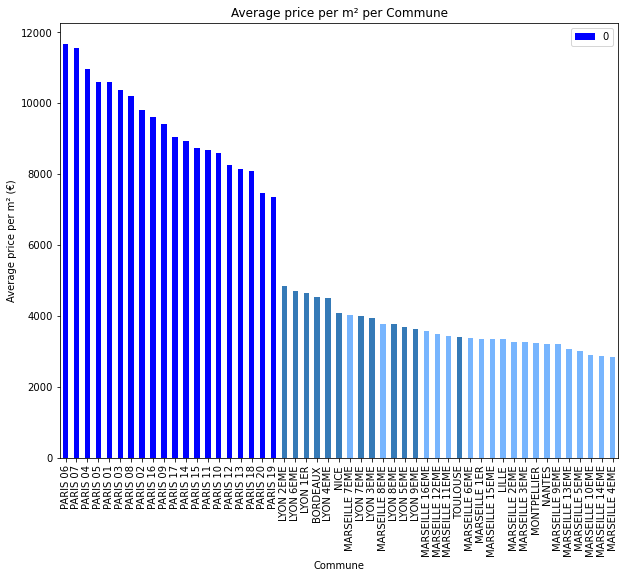

In [85]:
colors = { 0 : '#0000FF', 1 : '#357AB7', 2 : '#77B5FE' }

labels = list(colors.keys())


barplot2 = Cluster_df.plot.bar(x= 'Commune', y= 'PriceperM2', color = Cluster_df["Cluster"].map(colors))
barplot2.set_ylabel("Average price per m² (€)")
barplot2.set_title('Average price per m² per Commune')
barplot2.legend(labels)
plt.rcParams['figure.figsize'] = (11,3)

#### <span style="color:midnightblue"> Finding 2 conclusion:

Paris is still the city with the highest distribution of price per m². Some disctrict in Lyon seem to have lower prices per square meter than the average throughout the all city. Conversely, in Marseille, some distrits such as the 7ème and the 8ème seem to be valued neighbourhoods and might be observed over time. 
On the whole, undoubtedly, Paris is the highest valuable city in terme of price per m². The lowest valuable area goes to some district of Marseille. 

### <span style="color:midnightblue"> Finding 3 : Price/City per Year

In [57]:
!pip install datefinder

In [58]:
import datefinder

In [59]:
def find_date(dt) :
    matches = list(datefinder.find_dates(dt))
    if len(matches) > 0:
        date_ = matches[0]
    else : 
        date_ = None
    return date_

rdd_estate_nb_year = rdd_clean_realestate.map(lambda tuple: find_date(tuple[1]).year) 
rdd_estate_nb_year.distinct().count()

5

In [60]:
spark.sql("SELECT SUBSTRING(`Sale Date`, 4, 7) AS Date, \
          int(AVG(PriceM2)) AS `PRICE PER M²` \
          FROM transaction2\
          GROUP BY Date\
          ORDER BY Date").show()

+-------+------------+
|   Date|PRICE PER M²|
+-------+------------+
|01/2015|        5134|
|01/2016|        4674|
|01/2017|        5473|
|01/2018|        5665|
|01/2019|        5821|
|02/2015|        5070|
|02/2016|        4977|
|02/2017|        5384|
|02/2018|        5626|
|02/2019|        5922|
|03/2015|        5195|
|03/2016|        5170|
|03/2017|        5483|
|03/2018|        5774|
|03/2019|        5873|
|04/2015|        5078|
|04/2016|        5254|
|04/2017|        5444|
|04/2018|        5749|
|04/2019|        5929|
+-------+------------+
only showing top 20 rows



In [61]:
spark.sql("SELECT Cluster, SUBSTRING(`Sale Date`, 4, 7) AS Date, \
          int(AVG(PriceM2)) AS `PRICE PER M²` \
          FROM transaction2\
          GROUP BY Cluster, Date\
          ORDER BY Cluster, Date").show()

+-------+-------+------------+
|Cluster|   Date|PRICE PER M²|
+-------+-------+------------+
|      0|01/2015|        8211|
|      0|01/2016|        8160|
|      0|01/2017|        8716|
|      0|01/2018|        9337|
|      0|01/2019|        9832|
|      0|02/2015|        8377|
|      0|02/2016|        8277|
|      0|02/2017|        8709|
|      0|02/2018|        9253|
|      0|02/2019|        9997|
|      0|03/2015|        8117|
|      0|03/2016|        8222|
|      0|03/2017|        8747|
|      0|03/2018|        9290|
|      0|03/2019|       10010|
|      0|04/2015|        8126|
|      0|04/2016|        8428|
|      0|04/2017|        8877|
|      0|04/2018|        9459|
|      0|04/2019|       10000|
+-------+-------+------------+
only showing top 20 rows



In [62]:
df_3 = spark.sql("SELECT SUBSTRING(`Sale Date`, 4, 7) AS Date, \
          int(AVG(PriceM2)) AS `PRICE PER M²` \
          FROM transaction2\
          GROUP BY Date\
          ORDER BY Date").toPandas()
df_3

,Date,PRICE PER M²
0,01/2015,5134
1,01/2016,4674
2,01/2017,5473
3,01/2018,5665
4,01/2019,5821
5,02/2015,5070
6,02/2016,4977
7,02/2017,5384
8,02/2018,5626
9,02/2019,5922


In [63]:
df_cl = spark.sql("SELECT Cluster, SUBSTRING(`Sale Date`, 4, 7) AS Date, \
          int(AVG(PriceM2)) AS `PRICE PER M²` \
          FROM transaction2\
          GROUP BY Cluster, Date\
          ORDER BY Cluster, Date").toPandas()
df_cl


,Cluster,Date,PRICE PER M²
0,0,01/2015,8211
1,0,01/2016,8160
2,0,01/2017,8716
3,0,01/2018,9337
4,0,01/2019,9832
...,...,...,...
157,2,11/2018,3372
158,2,12/2015,3281
159,2,12/2016,3423
160,2,12/2017,3553


In [64]:
df_3['Date'] = pd.to_datetime(df_3['Date'], format='%m/%Y')
df_cl['Date'] = pd.to_datetime(df_cl['Date'], format='%m/%Y')

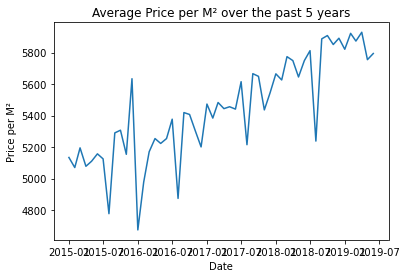

In [65]:
df_3 = df_3.sort_values(by='Date')
plt.plot(df_3['Date'], df_3['PRICE PER M²'])
plt.title("Average Price per M² over the past 5 years")
plt.xlabel("Date")
plt.ylabel("Price per M²")
plt.show()

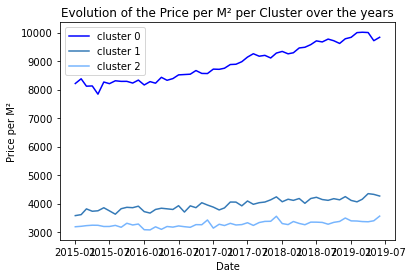

In [66]:
#colors = { 0 : '#0000FF', 1 : '#357AB7', 2 : '#77B5FE' }

df_cl_0 = df_cl[df_cl['Cluster'] == 0]
df_cl_0 = df_cl_0.sort_values(by='Date')

df_cl_1 = df_cl[df_cl['Cluster'] == 1]
df_cl_1 = df_cl_1.sort_values(by='Date')

df_cl_2 = df_cl[df_cl['Cluster'] == 2]
df_cl_2 = df_cl_2.sort_values(by='Date')


plt.plot(df_cl_0['Date'], df_cl_0['PRICE PER M²'], color='#0000FF', label="cluster 0")
plt.plot(df_cl_1['Date'], df_cl_1['PRICE PER M²'], color='#357AB7', label="cluster 1")
plt.plot(df_cl_2['Date'], df_cl_2['PRICE PER M²'], color='#77B5FE', label="cluster 2")

plt.title("Evolution of the Price per M² per Cluster over the years")
plt.xlabel("Date")
plt.ylabel("Price per M²")
plt.legend()
plt.show()

#### <span style="color:midnightblue"> Finding 3 conclusion:
On the first plot, From 2015 to 2019 the price per m² increases by 13,7% on average in our 9 cities.
On the Evolution of the Price per m2 in 5 years, we can observe than the price per m2 in the Cluster 0 composed by Paris increases more that in any other city. The increase of the price per m2 on cluster 1 and 2 is less than 5% where the increase in Paris is about 25% in 5 years. 


### <span style="color:midnightblue">  Finding 4: Attractivity and dynamism of the cities with the Number of transactions in 5 years 

In [67]:
spark.sql("SELECT City, count(*) as NBofTransactions, Cluster \
          FROM transaction2 \
          GROUP BY City, Cluster \
          ORDER BY NBofTransactions DESC").show()

+-----------+----------------+-------+
|       City|NBofTransactions|Cluster|
+-----------+----------------+-------+
|      PARIS|          141313|      0|
|  MARSEILLE|           56476|      2|
|   TOULOUSE|           45641|      1|
|       NICE|           34501|      1|
|       LYON|           32031|      1|
|     NANTES|           28784|      2|
|   BORDEAUX|           27412|      1|
|MONTPELLIER|           22389|      2|
|      LILLE|           21081|      2|
+-----------+----------------+-------+



In [68]:
nbTransaction_df = spark.sql("SELECT City, count(*) as NBofTransactions, Cluster \
          FROM transaction2 \
          GROUP BY City, Cluster \
          ORDER BY NBofTransactions DESC").toPandas()
nbTransaction_df

,City,NBofTransactions,Cluster
0,PARIS,141313,0
1,MARSEILLE,56476,2
2,TOULOUSE,45641,1
3,NICE,34501,1
4,LYON,32031,1
5,NANTES,28784,2
6,BORDEAUX,27412,1
7,MONTPELLIER,22389,2
8,LILLE,21081,2


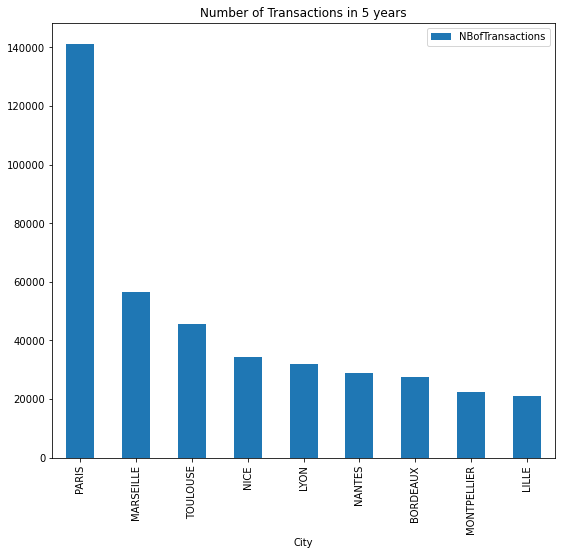

In [94]:
barplot_nbTransaction = nbTransaction_df.plot.bar(x='City', y='NBofTransactions')

barplot_nbTransaction.set_title('Number of Transactions in 5 years')

plt.rcParams['figure.figsize'] = (9,8)

#### <span style="color:midnightblue"> Finding 4 conclusion:

Within 5 years, according to the barplot above, the most attractive city in terms of number of transactions are Paris and Marseille. On the other hand, Lille and Montpellier have the less dynamic real estate markets.

### <span style="color:midnightblue">  Finding 5: Difference of number of House and Apartement sold per cities over the years

In [70]:
#number of houses and appartement sold per cities over the 5 years

spark.sql("SELECT City, `Local Type`, count(*) as NBofTransactions, Cluster \
          FROM transaction2 \
          GROUP BY City, `Local Type`, Cluster \
          ORDER BY NBofTransactions DESC").show()

+-----------+----------+----------------+-------+
|       City|Local Type|NBofTransactions|Cluster|
+-----------+----------+----------------+-------+
|      PARIS| APARTMENT|          140719|      0|
|  MARSEILLE| APARTMENT|           49134|      2|
|   TOULOUSE| APARTMENT|           39751|      1|
|       NICE| APARTMENT|           32906|      1|
|       LYON| APARTMENT|           31206|      1|
|     NANTES| APARTMENT|           22955|      2|
|   BORDEAUX| APARTMENT|           21457|      1|
|MONTPELLIER| APARTMENT|           20094|      2|
|      LILLE| APARTMENT|           16149|      2|
|  MARSEILLE|     HOUSE|            7342|      2|
|   BORDEAUX|     HOUSE|            5955|      1|
|   TOULOUSE|     HOUSE|            5890|      1|
|     NANTES|     HOUSE|            5829|      2|
|      LILLE|     HOUSE|            4932|      2|
|MONTPELLIER|     HOUSE|            2295|      2|
|       NICE|     HOUSE|            1595|      1|
|       LYON|     HOUSE|             825|      1|


In [71]:
NBofSaleType_df = spark.sql("SELECT City, `Local Type`, count(*) as NBofTransactions, Cluster \
          FROM transaction2 \
          GROUP BY City, `Local Type`, Cluster \
          ORDER BY NBofTransactions DESC").toPandas()

In [72]:
NBofSaleType_df

,City,Local Type,NBofTransactions,Cluster
0,PARIS,APARTMENT,140719,0
1,MARSEILLE,APARTMENT,49134,2
2,TOULOUSE,APARTMENT,39751,1
3,NICE,APARTMENT,32906,1
4,LYON,APARTMENT,31206,1
5,NANTES,APARTMENT,22955,2
6,BORDEAUX,APARTMENT,21457,1
7,MONTPELLIER,APARTMENT,20094,2
8,LILLE,APARTMENT,16149,2
9,MARSEILLE,HOUSE,7342,2


In [101]:
colors = { 'HOUSE' : '#39ff14', 'APARTMENT' : '#7f7f7f' }

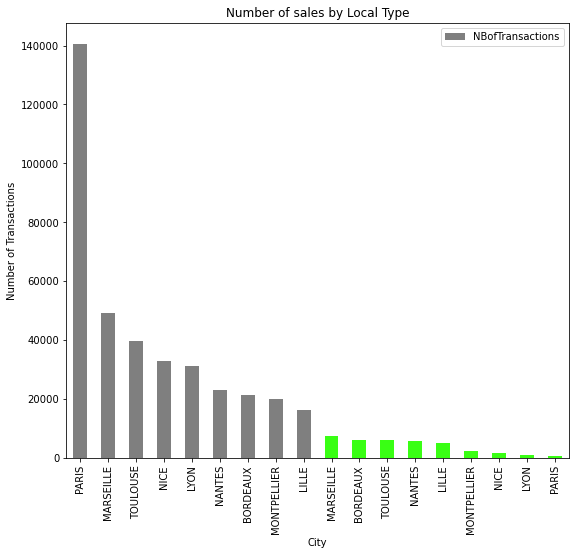

In [102]:
barplot_NBofSaletype = NBofSaleType_df.plot.bar(x='City', y='NBofTransactions', color=NBofSaleType_df["Local Type"].map(colors))

barplot_NBofSaletype.set_ylabel("Number of Transactions")

barplot_NBofSaletype.set_title('Number of sales by Local Type')

plt.rcParams['figure.figsize'] = (9,8)


#### <span style="color:midnightblue"> Finding 5 conclusion:

We can notice that the number of sales of apartments is significantly superior than the number of Houses sold. This gap will be wider over the years due to the phenomenon of gentrification.

### <span style="color:midnightblue"> Finding 6 : The Prices Difference between Houses and Apartment

In [75]:
spark.sql("SELECT City, `Local Type`, AVG(priceM2) AS PriceperM2, AVG(`Living Area`) as Surface, Cluster \
          FROM transaction2 \
          GROUP BY City, `Local Type`, Cluster \
          ORDER BY PriceperM2 DESC").show()

+-----------+----------+------------------+------------------+-------+
|       City|Local Type|        PriceperM2|           Surface|Cluster|
+-----------+----------+------------------+------------------+-------+
|      PARIS|     HOUSE|10744.194294426095|138.22222222222223|      0|
|      PARIS| APARTMENT| 8877.957681890763|53.741385313994556|      0|
|       NICE|     HOUSE| 5245.839710241555|118.22884012539186|      1|
|       LYON|     HOUSE|5077.7992301481445|119.84484848484848|      1|
|   BORDEAUX| APARTMENT|  4565.90405014624|58.168756116884936|      1|
|   BORDEAUX|     HOUSE| 4461.869842552145|109.01628883291352|      1|
|  MARSEILLE|     HOUSE| 4096.728755265125| 93.19667665486243|      2|
|       LYON| APARTMENT| 4054.641722389552| 64.87082612318144|      1|
|       NICE| APARTMENT| 4035.606814308394|56.306904515893756|      1|
|   TOULOUSE|     HOUSE|3688.5125325047497|105.01816638370119|      1|
|     NANTES|     HOUSE| 3664.694393476717|103.87150454623435|      2|
|     

In [76]:
PriceType_df = spark.sql("SELECT City, `Local Type`, AVG(priceM2) AS PriceperM2, AVG(`Living Area`) as Surface, Cluster \
          FROM transaction2 \
          GROUP BY City, `Local Type`, Cluster \
          ORDER BY PriceperM2 DESC").toPandas()
PriceType_df

,City,Local Type,PriceperM2,Surface,Cluster
0,PARIS,HOUSE,10744.194294,138.222222,0
1,PARIS,APARTMENT,8877.957682,53.741385,0
2,NICE,HOUSE,5245.839710,118.228840,1
3,LYON,HOUSE,5077.799230,119.844848,1
4,BORDEAUX,APARTMENT,4565.904050,58.168756,1
5,BORDEAUX,HOUSE,4461.869843,109.016289,1
6,MARSEILLE,HOUSE,4096.728755,93.196677,2
7,LYON,APARTMENT,4054.641722,64.870826,1
8,NICE,APARTMENT,4035.606814,56.306905,1
9,TOULOUSE,HOUSE,3688.512533,105.018166,1


In [98]:
PriceType_pivot = PriceType_df.pivot(index='City', columns='Local Type', values='PriceperM2').fillna(0)


In [99]:
PriceType_pivot

Local Type,APARTMENT,HOUSE
City,,
BORDEAUX,4565.904050,4461.869843
LILLE,3597.417375,2480.535417
LYON,4054.641722,5077.799230
MARSEILLE,3192.510257,4096.728755
MONTPELLIER,3225.961148,3435.509841
NANTES,3104.432637,3664.694393
NICE,4035.606814,5245.839710
PARIS,8877.957682,10744.194294
TOULOUSE,3376.965718,3688.512533


Text(0.5, 1.0, 'Price per Local Type per City')

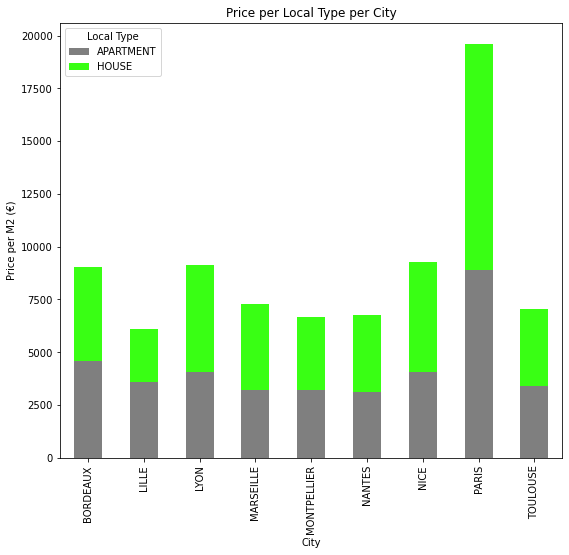

In [103]:
barplot = PriceType_pivot.plot(kind='bar', stacked=True, color = colors)


barplot.set_ylabel("Price per M2 (€)")

barplot.set_title("Price per Local Type per City")


#### <span style="color:midnightblue"> Finding 6 conclusion:

We can notice a slight difference of price per m2 between House and apartment in the cities. The biggest difference of prices is in Paris: a house is 20% more expensive than an apartment. We can explain this easily, indeed, the houses offers on a city or around it, is more rare. This is the typical law of supply and demand.